<a href="https://colab.research.google.com/github/Jesus21A/FromRawDataToIntelligentPredictionsv2/blob/main/FromRawDataToIntelligentPredictionsv2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

--- CONFIGURANDO ENTORNO KAGGLE (SI ES NECESARIO) ---
La API de Kaggle ya parece estar configurada.

El archivo 'powerconsumption.csv' ya existe.

--- MODELO V2: INICIANDO SCRIPT DE COMPARACIÓN ---
Datos divididos: 41932 para entrenamiento, 10484 para prueba.
Secuencias creadas. Forma de X_train: (41788, 144, 6)
Secuencias creadas. Forma de X_test: (10340, 144, 6)


Model: "Modelo_V2_Estandarizado"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_2 (Conv1D)               │ (None, 142, 64)        │         1,216 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_2 (MaxPooling1D)  │ (None, 71, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 50)             │        23,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 24,267 (94.79 KB)

 Trainable params: 24,267 (94.79 KB)

 Non-trainable params: 0 (0.00 B)


--- ENTRENANDO MODELO V2 ---
Epoch 1/20
1306/1306 ━━━━━━━━━━━━━━━━━━━━ 63s 46ms/step - loss: 0.0142 - val_loss: 6.4150e-04
Epoch 2/20
1306/1306 ━━━━━━━━━━━━━━━━━━━━ 83s 47ms/step - loss: 6.4788e-04 - val_loss: 4.3607e-04
Epoch 3/20
1306/1306 ━━━━━━━━━━━━━━━━━━━━ 80s 46ms/step - loss: 4.0065e-04 - val_loss: 3.2370e-04
Epoch 4/20
1306/1306 ━━━━━━━━━━━━━━━━━━━━ 81s 45ms/step - loss: 3.6926e-04 - val_loss: 2.9078e-04
Epoch 5/20
1306/1306 ━━━━━━━━━━━━━━━━━━━━ 63s 48ms/step - loss: 3.3271e-04 - val_loss: 2.3959e-04
Epoch 6/20
1306/1306 ━━━━━━━━━━━━━━━━━━━━ 79s 46ms/step - loss: 3.2334e-04 - val_loss: 2.3959e-04
Epoch 7/20
1306/1306 ━━━━━━━━━━━━━━━━━━━━ 84s 48ms/step - loss: 3.1201e-04 - val_loss: 2.1117e-04
Epoch 8/20
1306/1306 ━━━━━━━━━━━━━━━━━━━━ 62s 48ms/step - loss: 2.9593e-04 - val_loss: 1.9840e-04
Epoch 9/20
1306/1306 ━━━━━━━━━━━━━━━━━━━━ 60s 46ms/step - loss: 2.8669e-04 - val_loss: 1.9839e-04
Epoch 10/20
1306/1306 ━━━━━━━━━━━━━━━━━━━━ 62s 47ms/step - loss: 2.7636e-04 - val_loss: 1.91

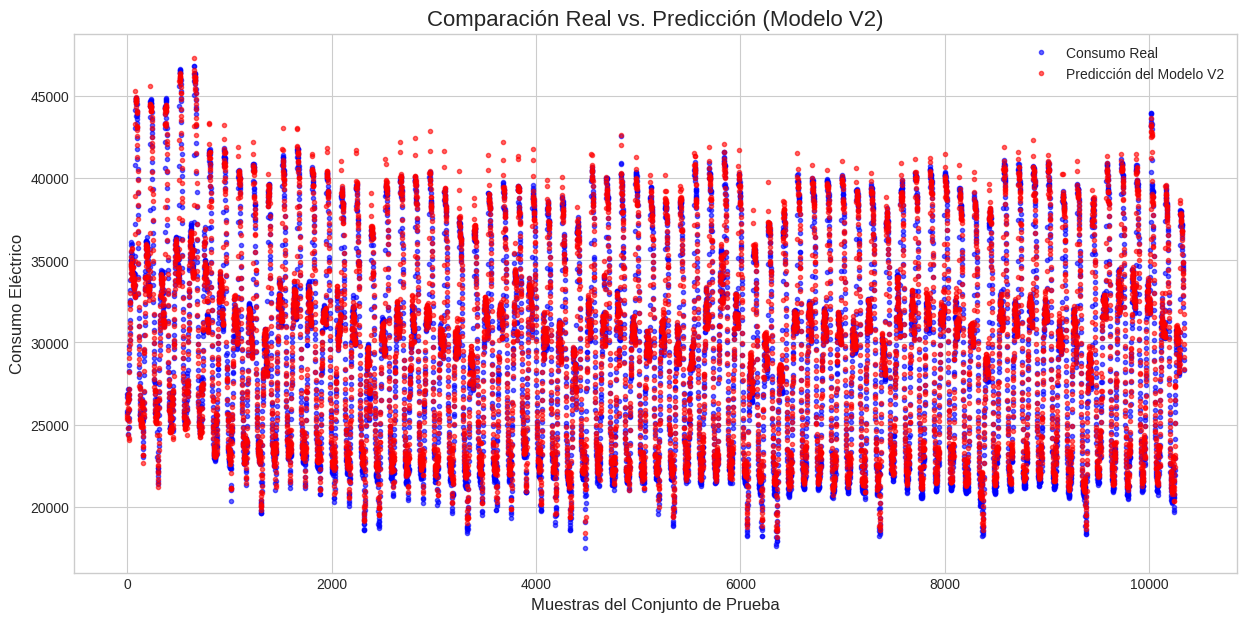

In [3]:
# ==============================================================================
# MODELO V2: MULTIVARIADO (VERSIÓN DE COMPARACIÓN JUSTA Y ESTANDARIZADA)
# Script completo con descarga de datos desde Kaggle.
# ==============================================================================
import pandas as pd
import numpy as np
import tensorflow as tf
import random
import os
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Conv1D, MaxPooling1D, LSTM, Dense

# --- 0. CONFIGURACIÓN DE KAGGLE Y DESCARGA DE DATOS ---
print("--- CONFIGURANDO ENTORNO KAGGLE (SI ES NECESARIO) ---")
if not os.path.exists('/root/.kaggle'):
    # Asegúrate de que tu 'kaggle.json' está en el directorio de trabajo.
    if os.path.exists('kaggle.json'):
        os.system('pip install -q kaggle')
        os.system('mkdir -p ~/.kaggle')
        os.system('cp kaggle.json ~/.kaggle/')
        os.system('chmod 600 ~/.kaggle/kaggle.json')
        print("API de Kaggle configurada.")
    else:
        print("ADVERTENCIA: No se encontró 'kaggle.json'.")
else:
    print("La API de Kaggle ya parece estar configurada.")

csv_filename = 'powerconsumption.csv'
if not os.path.exists(csv_filename):
    print(f"\n'{csv_filename}' no encontrado. Descargando desde Kaggle...")
    # El siguiente comando requiere que la API de Kaggle esté configurada.
    os.system('kaggle datasets download -d fedesoriano/electric-power-consumption')
    os.system('unzip -o electric-power-consumption.zip')
    if os.path.exists(csv_filename):
        print("Dataset descargado y descomprimido.")
    else:
        print("Error: La descarga falló. Asegúrate de que tu API de Kaggle funciona.")
        exit()
else:
    print(f"\nEl archivo '{csv_filename}' ya existe.")


# --- 1. CONFIGURACIÓN Y REPRODUCIBILIDAD ---
print("\n--- MODELO V2: INICIANDO SCRIPT DE COMPARACIÓN ---")
seed_value = 42
os.environ['PYTHONHASHSEED'] = str(seed_value)
random.seed(seed_value)
np.random.seed(seed_value)
tf.random.set_seed(seed_value)

# --- 2. CARGA DE DATOS ---
df = pd.read_csv(csv_filename, parse_dates=['Datetime'])
df = df.set_index('Datetime').sort_index()

# Seleccionamos las características. El objetivo DEBE ser la primera columna.
TARGET_VARIABLE = 'PowerConsumption_Zone1'
# Simplificamos V2 para un diagnóstico justo, quitando 'hour' y 'day_of_week' por ahora.
feature_columns = ['Temperature', 'Humidity', 'WindSpeed', 'GeneralDiffuseFlows', 'DiffuseFlows']
ordered_columns = [TARGET_VARIABLE] + feature_columns
df_features = df[ordered_columns]

# --- 3. DIVISIÓN DE DATOS ESTANDARIZADA ---
train_size = int(len(df_features) * 0.8)
train_df = df_features.iloc[:train_size]
test_df = df_features.iloc[train_size:]
print(f"Datos divididos: {len(train_df)} para entrenamiento, {len(test_df)} para prueba.")

# --- 4. PREPROCESAMIENTO (ESCALADO) CORRECTO ---
scaler = MinMaxScaler(feature_range=(0, 1))
scaler.fit(train_df)
scaled_train_data = scaler.transform(train_df)
scaled_test_data = scaler.transform(test_df)

# --- 5. CREACIÓN DE SECUENCIAS (VENTANAS DE TIEMPO) SEGURA ---
def create_sequences(data, n_steps_in, n_steps_out):
    X, y = [], []
    target_col_index = 0
    for i in range(len(data) - n_steps_in - n_steps_out + 1):
        seq_x = data[i : i + n_steps_in, :]
        seq_y = data[i + n_steps_in : i + n_steps_in + n_steps_out, target_col_index]
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)

N_STEPS_IN = 144
N_STEPS_OUT = 1
N_FEATURES = scaled_train_data.shape[1]

X_train, y_train = create_sequences(scaled_train_data, N_STEPS_IN, N_STEPS_OUT)
X_test, y_test = create_sequences(scaled_test_data, N_STEPS_IN, N_STEPS_OUT)
print(f"Secuencias creadas. Forma de X_train: {X_train.shape}")
print(f"Secuencias creadas. Forma de X_test: {X_test.shape}")

# --- 6. CONSTRUCCIÓN DEL MODELO V2 ---
model_v2 = Sequential(name="Modelo_V2_Estandarizado")
model_v2.add(Input(shape=(N_STEPS_IN, N_FEATURES)))
model_v2.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
model_v2.add(MaxPooling1D(pool_size=2))
model_v2.add(LSTM(50, activation='relu'))
model_v2.add(Dense(N_STEPS_OUT))
model_v2.compile(optimizer='adam', loss='mse')
model_v2.summary()

# --- 7. ENTRENAMIENTO ---
print("\n--- ENTRENANDO MODELO V2 ---")
history = model_v2.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_test, y_test), verbose=1, shuffle=False)

# --- 8. EVALUACIÓN ---
print("\n--- EVALUANDO MODELO V2 ---")
predictions_scaled = model_v2.predict(X_test)

# Des-normalizar para la evaluación (método robusto)
dummy_predictions = np.zeros((len(predictions_scaled), N_FEATURES))
dummy_actuals = np.zeros((len(y_test), N_FEATURES))
dummy_predictions[:, 0] = predictions_scaled.flatten()
dummy_actuals[:, 0] = y_test.flatten()
predictions = scaler.inverse_transform(dummy_predictions)[:, 0]
actuals = scaler.inverse_transform(dummy_actuals)[:, 0]

mse = mean_squared_error(actuals, predictions)
mae = mean_absolute_error(actuals, predictions)
print(f"\nResultados Finales Modelo V2:")
print(f"  - Error Cuadrático Medio (MSE): {mse:.2f}")
print(f"  - Error Absoluto Medio (MAE):   {mae:.2f}")

# Visualización
plt.style.use('seaborn-v0_8-whitegrid')
plt.figure(figsize=(15, 7))
plt.plot(actuals.flatten(), label='Consumo Real', color='blue', marker='.', linestyle='None', alpha=0.6)
plt.plot(predictions.flatten(), label='Predicción del Modelo V2', color='red', marker='.', linestyle='None', alpha=0.6)
plt.title('Comparación Real vs. Predicción (Modelo V2)', fontsize=16)
plt.xlabel('Muestras del Conjunto de Prueba', fontsize=12)
plt.ylabel('Consumo Eléctrico', fontsize=12)
plt.legend()
plt.show()

